In [22]:
%matplotlib inline
import re
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.constants import hbar, e as eV, c
eh = eV/hbar
import glob
def ri(z): return (z.real, z.imag)
#m = re.compile(r"([^_]+)_r([0-9.]+)nm_")
#removek = re.compile(r"(k\([^)]+\)um-1_)")
remover = re.compile(r"r[0-9.]+nm_")


markerdict = {
    4: "3",
    -4: "4",
    3: "^",
    -3: "v",
    -2: 'x',
    2: '+',
    1: 's',
    -1: 'd',
}


D4h_irlabels = {"B2''":"$B_2''$",
                "B2'":"$B_2'$",
                "A1''":"$A_1''$",
                "A1'":"$A_1'$",
                "A2''":"$A_2''$",
                "B1''":"$B_1''$",
                "A2'":"$A_2'$", 
                "B1'":"$B_1'$",
                "E'":"$E'$",
                "E''":"$E''$",}


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colordict = {i: colors[(i+1)] for i in range(-4,8)}

def markerfun(b):
    if b in markerdict.keys():
        return markerdict[b]
    else: return 'X'

def colorfun(b):
    if (b+1) in colordict.keys():
        return colordict[b+1]
    else: return colordict[0]

In [3]:
allfiles=glob.glob('*sph*k(0_0)*.npz')
allgraphs=dict()
for f in allfiles:
    base = remover.sub('', f)
    if base in allgraphs.keys():
        allgraphs[base] += 1
    else:
        allgraphs[base] = 1
for k in sorted(allgraphs.keys()):
    print(k, allgraphs[k])

sph_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L1_cn410.npz 203
sph_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L2_cn410.npz 251
sph_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L3_cn410.npz 251
sph_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L4_cn410.npz 251
sph_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L5_cn410.npz 251


In [4]:
projectors = dict()
projectors_list = dict()
lMaxes = [lMax for lMax in range(1,6)]
for lMax in lMaxes:
    proj = np.load('projectors_D4h_lMax%d.npz' % lMax)
    irlabels = sorted(proj.keys())
    proj =  {f: proj[f] for f in irlabels}
    proj_list = [proj[irlabels[i]] for i in range(len(proj))]
    projectors[lMax] = proj
    projectors_list[lMax] = proj_list
globpattern = '*sph_r*_p580nmx580nm_mAu_n1.52_b?2_k(0_0)um-1_L?_cn???.npz'
filenames=glob.glob(globpattern)
plotfilename = 'collected_' + globpattern.replace('*', 'XXX').replace('?', 'X').replace('npz','pdf')
print(filenames[:4], plotfilename)


['sph_r281nm_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L4_cn410.npz', 'sph_r121nm_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L3_cn410.npz', 'sph_r67nm_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L3_cn410.npz', 'sph_r208nm_p580nmx580nm_mAu_n1.52_b-2_k(0_0)um-1_L3_cn410.npz'] collected_XXXsph_rXXX_p580nmx580nm_mAu_n1.52_bX2_k(0_0)um-1_LX_cnXXX.pdf


In [5]:
#projectors
#glob.glob('cyl_r100nm*L3*3100.npz')
#glob.glob('sph_r100*m5*.npz')
#dat['meta'][()],list(dat.keys())

In [6]:
plotdata = {}
for file in filenames:
    dat = np.load(file, allow_pickle=True)
    kx = dat['meta'][()]['k'][0]
    radius = dat['meta'][()]['radius']
    b = dat['meta'][()]['band_index']
    eigvals = dat['eigval']
    lMax = dat['meta'][()]['lMax']
    residuals = dat['residuals']
    ef =dat['empty_freqs']
    eigvecs = dat['eigvec']
    irweights = []
    #for proj in projectors_list[lMax]:
    #    try:
    #        irweights.append(np.linalg.norm(np.tensordot(proj, eigvecs, axes=(-1, -1)), axis=0,ord=2) if len(proj) != 0 else np.zeros((len(eigvecs),)))
    #    except ValueError as err:
    #        print(proj, len(proj))
    #        raise err
    irweights = np.array(irweights)
    #print(irweights)
    irweights = np.array([np.linalg.norm(np.tensordot(proj, eigvecs, axes=(-1, -1)), axis=0,ord=2) if len(proj) != 0 else np.zeros((len(eigvecs),)) for proj in projectors_list[lMax]]).T
    irclass = np.argmax(irweights, axis=-1)
    purities = np.amax(irweights, axis=-1)
    if (np.any(purities < 0.98)):
        print("inpure result detected", purities, residuals)
    #print(purities)
    
    #for i in range(len(residuals)): 
    #    if residuals[i] < 0.01:
    #        vec = eigvecs[i]
    #        for irlabel, proj in projectors.items():
    #            print(irlabel, np.linalg.norm(np.dot(proj, vec))) #maybe some conj() here?
    #        print('--->', irlabels[irclass[i]])

    
    plotdata[(lMax,radius)] = (eigvals, residuals, b, ef, irclass,)


inpure result detected [1.         1.         0.92521572 1.         0.99999627 0.99990293
 0.99946049] [1.59712906e-05 3.60193407e-05 2.48341492e-01 1.21848930e-03
 3.81805601e-03 2.42649228e-02 2.99534246e-02]
inpure result detected [1.         1.         0.99999998 0.99999999 0.99999996 0.96608887
 0.99999852 0.99999397 0.99998951 0.99999912 0.99982435] [2.66223026e-04 2.12357147e-05 3.54211968e-05 1.06651057e-04
 2.79595790e-04 2.41939163e-01 2.17645058e-03 3.41541473e-03
 1.14507609e-02 1.49639498e-02 2.33483138e-02]
inpure result detected [1.         0.99999999 1.         0.97991334 0.99999996 0.9999989
 0.99999983 0.99999966 0.99999322 0.99999721 0.99999653] [3.28735741e-04 2.66532534e-05 2.47011478e-05 1.45012420e-01
 2.44785416e-04 7.05405359e-04 1.60203586e-03 1.71245137e-03
 1.03244480e-02 9.18732728e-03 1.18651583e-02]
inpure result detected [1.         1.         0.99999998 0.99999961 0.93267685 0.99999964
 0.99999822 0.99921774 0.99995547 0.99997301] [5.22490396e-04 3.0155

collected_XXXsph_rXXX_p580nmx580nm_mAu_n1.52_bX2_k(0_0)um-1_LX_cnXXX.pdf


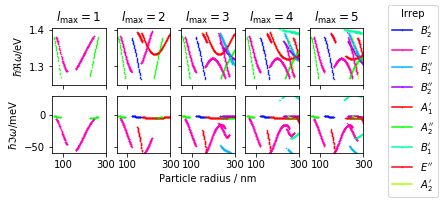

In [23]:
fig = plt.figure(figsize=(6,3))
axesR = {}
axesI = {}
for i, lMax in enumerate(lMaxes):
    axesR[lMax] = fig.add_subplot(2,len(lMaxes),i+1)
    axesR[lMax].set_xlim([50,300])
    axesR[lMax].set_ylim([1.25, ef[1]/eh])
    axesI[lMax] = fig.add_subplot(2,len(lMaxes),len(lMaxes)+i+1)
    axesI[lMax].set_xlim([50,300])
    axesI[lMax].set_ylim([-60, 30])
    axesR[lMax].set_title('$l_\max = %d $' % lMax)    
    axesR[lMax].tick_params(labelbottom=False) 
    if i == len(lMaxes)//2:
        axesI[lMax].set_xlabel("Particle radius / nm")
    if i == 0:
        axesR[lMax].set_ylabel('$\hbar \Re \omega / \mathrm{eV}$')
        axesI[lMax].set_ylabel('$\hbar \Im \omega / \mathrm{meV}$')
    else:
        axesR[lMax].tick_params(labelleft=False) 
        axesI[lMax].tick_params(labelleft=False) 
    axesR[lMax].set_xticks([100,300])
    axesI[lMax].set_xticks([100,300])

res_thr = 0.00015

ir_labeled=set()
if True:
  for (lMax, radius), (eigvals, residuals, b, ef, irclass) in plotdata.items():
    for i, (e, res, iri) in enumerate(zip(eigvals, residuals, irclass)):
        #if i == 0:
        if res < res_thr:# and e.real < 2.14e15:
            if iri in ir_labeled: 
                label=None
            else:
                ir_labeled.add(iri)
                label=D4h_irlabels[irlabels[iri]]
            axesR[lMax].plot(radius*1e9, e.real/eh, 
                             marker='.',
                             #marker=markerfun(b),
                    ms=1, #c=colorfun(b)
                    c=matplotlib.cm.hsv(iri/9),
                    #c = colorfun(iri),
                    label=label,
                   )
            axesI[lMax].plot(radius*1e9, e.imag/eh*1000, 
                    #marker='x', 
                    #c=colorfun(b), 
                    c=matplotlib.cm.hsv(iri/9),#colorfun(iri),
                    marker='.', #markerfun(b),
                             ms=1,
                    #label=label
                            )
fig.legend(title="Irrep", loc="upper right")
plt.subplots_adjust(bottom=0.3, right=0.82,left=0.10)
#fig.suptitle('$l_\mathrm{max}=%d$, residual threshold = %g' % (lMax, res_thr) )
fig.savefig(plotfilename)
fig.savefig(plotfilename.replace('pdf', 'png'))
print(plotfilename)

In [9]:
ef / eh

array([0.        , 1.40635433, 1.98888536, 2.81270865, 3.14470387,
       3.97777072, 4.21906298, 4.44728287])

In [11]:
len(plotdata)

1207

In [12]:
irclass

array([5, 3, 5, 0, 7, 8, 8, 9, 9])